In [1]:
import json
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from cplAE_MET.utils.load_helpers import get_MET_dataset, get_paths
from cplAE_MET.utils.analysis_helpers import load_model_e1, get_gene_subsets, get_E_feature_dict

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [2]:
paths = get_paths()
model_wt_path = f'{str(paths["package"])}/data/results/MET_3819_e1_aug/TME_alpha_1-0_1-0_5-0_cs_1-0-1-0-1-0_ad_1_ld_3_bs_300_se_500_ne_1000_ri_0_train_best_loss-weights.h5'
summary_path  = f'{str(paths["package"])}/data/results/MET_3819_e1_aug/TME_alpha_1-0_1-0_5-0_cs_1-0-1-0-1-0_ad_1_ld_3_bs_300_se_500_ne_1000_ri_0_train_best_loss-summary.mat'

In [3]:
O = get_MET_dataset()
M_anno = pd.read_csv(paths['v2_m_anno'])
T_anno = pd.read_csv(paths['v2_t_anno'])
T_data = pd.read_csv(paths['v2_t_data'])
E_data = pd.read_csv(paths['v2_e_data'])
O['genes'] = T_data.columns[1:].values
O['features'] = E_data.columns[1:].values

D = sio.loadmat(summary_path,squeeze_me=True)

#sort indices to make some dataframe lookups easier
D['train_ind'] = np.sort(D['train_ind'])
D['val_ind'] = np.sort(D['val_ind'])

model = load_model_e1(model_wt_path = model_wt_path)
gene_subsets = get_gene_subsets()

In [4]:
# Cross modal data predictions: M-->T and M-->E
zM = model.encoder_M(O['XM'][D['val_ind'],...])

XM_to_XT = model.decoder_T(zM)
XM_to_XE = model.decoder_E(zM)

XM_to_XT = XM_to_XT.numpy()
XM_to_XE = XM_to_XE.numpy()

In [5]:
m_avbl = M_anno[M_anno['reconstruction']!='none']
m_avbl_well_sampled = m_avbl.groupby('cluster').filter(lambda x: len(x) > 15)
unique_classes = m_avbl_well_sampled['cluster'].unique() #ordered celltypes for well sampled morphologies

In [6]:
m_avbl_well_sampled['cluster'].value_counts(sort=False)[unique_classes]

Lamp5 Plch2 Dock5     29
Lamp5 Lsp1            24
Vip Lmo1 Myl1         20
Vip Crispld2 Kcne4    22
Sst Chodl             24
Sst Tac1 Htr1d        18
Sst Calb2 Pdlim5      49
Sst Hpse Cbln4        42
Sst Crhr2 Efemp1      25
Sst Esm1              25
Sst Tac2 Tacstd2      16
Pvalb Sema3e Kank4    38
Pvalb Reln Itm2a      53
Pvalb Tpbg            41
Name: cluster, dtype: int64

In [7]:
m_train_ind = D['train_ind'].copy()
m_train_ind = m_train_ind[np.isin(m_train_ind,m_avbl_well_sampled.index.values)]

In [8]:
train_labels = O['cluster'][m_train_ind]
train_zM = model.encoder_M(O['XM'][m_train_ind,...])
classifier = KNN(n_neighbors=5,p=2)
#classifier = QDA()
classifier.fit(train_zM, train_labels)
pred_labels = classifier.predict(zM)
true_labels = O['cluster'][D['val_ind']]

In [9]:
class_pred_df = pd.DataFrame({'true':true_labels,'pred':pred_labels})
class_pred_df[class_pred_df['true']==unique_classes[0]]

,true,pred
0,Lamp5 Plch2 Dock5,Sst Hpse Cbln4
1,Lamp5 Plch2 Dock5,Lamp5 Plch2 Dock5
2,Lamp5 Plch2 Dock5,Pvalb Tpbg
3,Lamp5 Plch2 Dock5,Sst Calb2 Pdlim5
4,Lamp5 Plch2 Dock5,Lamp5 Plch2 Dock5


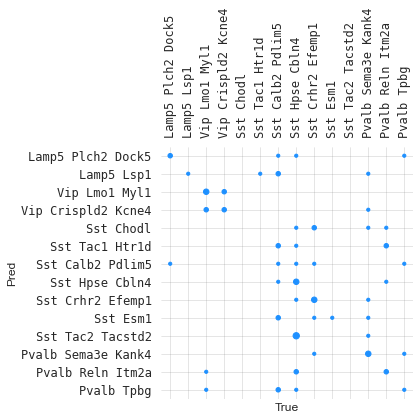

In [10]:
from cplAE_TE.utils.compute import contingency
from cplAE_TE.utils.plots import matrix_scatterplot
M = contingency(true_labels, pred_labels, unique_classes, unique_classes)
unique_classes_list = unique_classes.tolist()
matrix_scatterplot(M, unique_classes_list.copy(), unique_classes_list.copy(), 
                  xlabel='True', ylabel='Pred', mc='dodgerblue', 
                  fig_width=6, fig_height=6, scale_factor=10)

plt.savefig(paths['package'] / 'assets/M_to_Ttype_prediction.png',dpi=300)

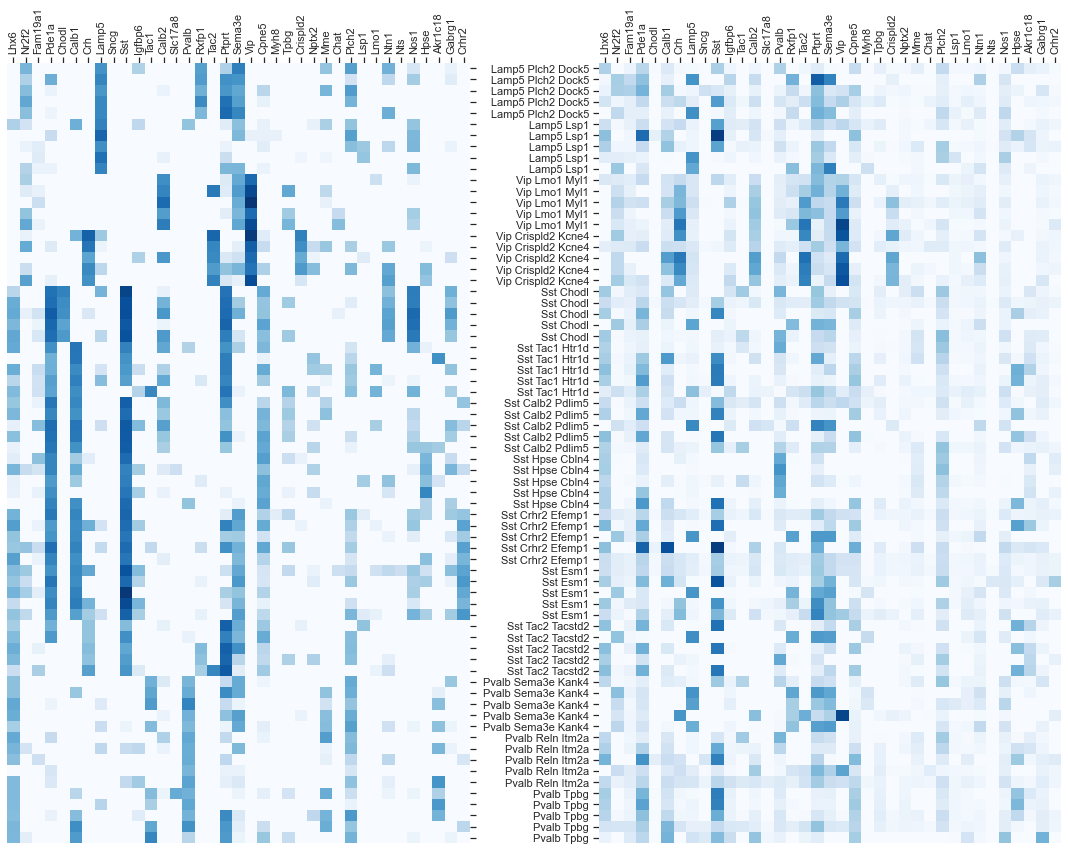

In [11]:
gene_ind = np.flatnonzero(np.isin(O['genes'],gene_subsets['combined_markers']))
M_true = O['XT'][D['val_ind'],...]
M_pred = XM_to_XT
M_true = M_true[:,gene_ind]
M_pred = M_pred[:,gene_ind]
xlabels = O['genes'][gene_ind].tolist()
xlabels = O['genes'][gene_ind].tolist()
ylabels= O['cluster'][D['val_ind']].tolist()

plt.figure(figsize = (15,12))
ax = plt.subplot(1,2,1)
sns.heatmap(M_true,annot=False,vmin=0,vmax=10,cbar=False,
            cmap=sns.color_palette("Blues", as_cmap=True),ax=ax)

ax.set_yticks(np.arange(0,M_true.shape[0])+0.5)
ax.set_yticklabels(['']*len(ylabels),rotation=0)
ax.set_xticks(np.arange(M_true.shape[1])+0.5)
ax.set_xticklabels(xlabels,rotation=90)
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('right')

ax = plt.subplot(1,2,2)
sns.heatmap(M_pred,annot=False,vmin=0,vmax=10,cbar=False,
            cmap=sns.color_palette("Blues", as_cmap=True),ax=ax)

ax.set_yticks(np.arange(0,M_pred.shape[0])+0.5)
ax.set_yticklabels(ylabels,rotation=0)
ax.set_xticks(np.arange(M_pred.shape[1])+0.5)
ax.set_xticklabels(xlabels,rotation=90)
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')
plt.tight_layout()

plt.savefig(paths['package'] / 'assets/M_to_T_prediction.png',dpi=300)

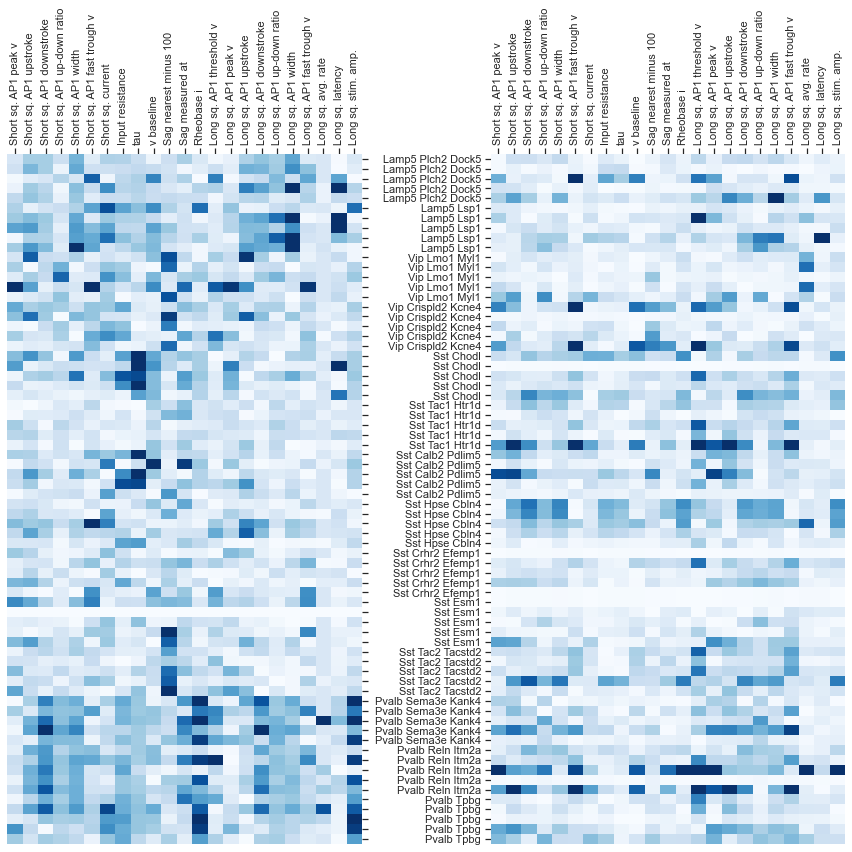

In [12]:
# get easy to read feature names
Lookup = get_E_feature_dict()
O['features'] = np.array([Lookup[feature] for feature in O['features']])

feature_ind = np.arange(45,68,1)
M_true = O['XE'][D['val_ind'],...]
M_pred = XM_to_XE
M_true = M_true[:,feature_ind]
M_pred = M_pred[:,feature_ind]
M_true = np.abs(M_true)
M_pred = np.abs(M_pred)
xlabels = O['features'][feature_ind].tolist()
ylabels= O['cluster'][D['val_ind']].tolist()

plt.figure(figsize = (12,12))
ax = plt.subplot(1,2,1)
sns.heatmap(M_true,annot=False,vmin=0,vmax=3,cbar=False,
            cmap=sns.color_palette("Blues", as_cmap=True),ax=ax)

ax.set_yticks(np.arange(0,M_true.shape[0])+0.5)
ax.set_yticklabels(['']*len(ylabels),rotation=0)
ax.set_xticks(np.arange(M_true.shape[1])+0.5)
ax.set_xticklabels(xlabels,rotation=90)
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('right')

ax = plt.subplot(1,2,2)
sns.heatmap(M_pred,annot=False,vmin=0,vmax=3,cbar=False,
            cmap=sns.color_palette("Blues", as_cmap=True),ax=ax)

ax.set_yticks(np.arange(0,M_pred.shape[0])+0.5)
ax.set_yticklabels(ylabels,rotation=0)
ax.set_xticks(np.arange(M_pred.shape[1])+0.5)
ax.set_xticklabels(xlabels,rotation=90)
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')
plt.tight_layout()

plt.savefig(paths['package'] / 'assets/M_to_E_prediction.png',dpi=300)

In [13]:
# Cross modal T-->M reconstructions
zT = model.encoder_T(O['XT'][D['val_ind'],...])
XT_to_XM = model.decoder_M(zT)
X_true = O['XM'][D['val_ind']]
X_pred = XT_to_XM
ctypes = O['cluster'][D['val_ind']]

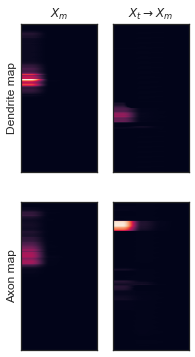

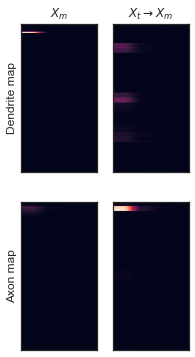

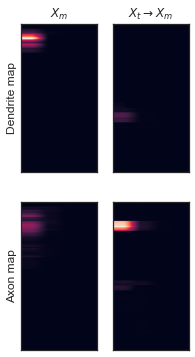

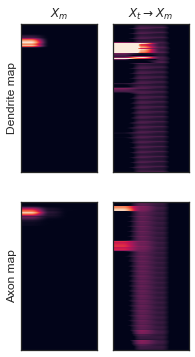

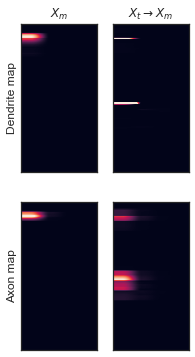

In [14]:
# Inspect density maps reconstructions
from cplAE_MET.utils.plots import show_ax_de_maps
for i in range(5):
    show_ax_de_maps(X_true[i], X_pred[i])
    #plt.savefig(paths['package'] / f'assets/T_to_M_{ctypes[i]}_{i}.png',dpi=300)
    plt.show()
    print('=========')

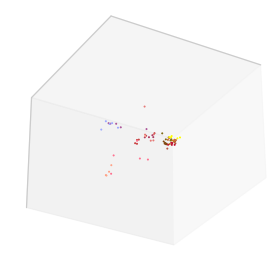

In [15]:
# Inspect representations interactively - switch to qt5
%matplotlib inline
from cplAE_MET.utils.plots import scatter3

ind = D['val_ind'].copy()
xlims=(-3,3)
ylims=(-3,3)
zlims=(-3,3)
fig = plt.figure(figsize=(5,4))
ax,sc = scatter3(D['zE'][ind,:],O['cluster_color'][ind],xlims,ylims,zlims,fig)
ax.view_init(elev=-30, azim=60)